# 투빅스 15기 정규세션 10주차 DCGAN 구현 과제
"빈칸" 부분을 채우는 과제입니다. "빈칸"뿐만 아니라 중간중간 주석 또는 마크다운으로 설명 부탁드립니다  
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드로 해당 코드를 바탕으로 과제를 만들었습니다. 튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋을 것 같습니다  
다만, 그대로 복붙이 아닌 코드를 이해해 나가면서 과제를 수행해주시기 바랍니다  
마지막 과제인 만큼 다들 화이팅!

## 드라이브 연결

In [1]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/tobigs')

Mounted at /content/gdrive


## 패키지 임포트

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [3]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= False,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

### 데이터 확인하기

In [4]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


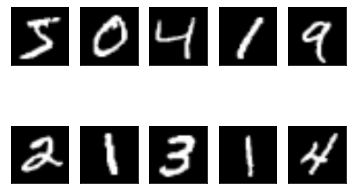

In [5]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [6]:
# dataloader
batch_size = 128
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [7]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 신경망 

In [52]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training, images 인풋 이미지 채널 수 
nz = 100 # size of z latent vector, z차원수
ngf = 64 # size of feature maps in generator, 
ndf = 64 # size of feature maps in discriminator,


### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [53]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/
![](https://blog.kakaocdn.net/dn/vqhJj/btqEdxkQ5qF/c97mGecm8vzGwj68d8uogK/img.png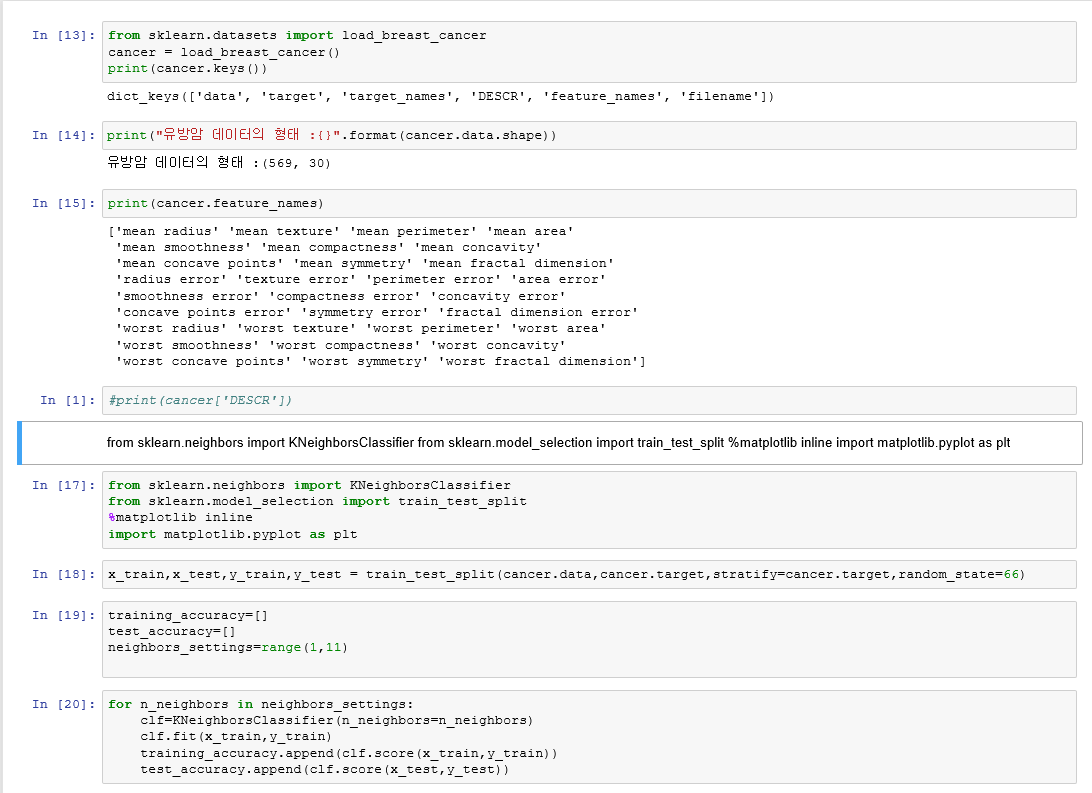)

![](https://blog.kakaocdn.net/dn/vqhJj/btqEdxkQ5qF/c97mGecm8vzGwj68d8uogK/img.png)

In [29]:
print(1024/64)
print(512/64)

16.0
8.0


In [19]:
from torchsummary import summary

In [51]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(100, 64, kernel_size=4, stride=1, bias=False),
        nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.ConvTranspose2d(64, 64, kernel_size=7, stride=1, bias=False),
        nn.ConvTranspose2d(64, 64, kernel_size=7, stride=1, bias=False),
        )

  def forward(self, input):
    return self.layer1(input)

input, _ = dataset[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Net().to(device)

summary(model, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 4, 4]         102,400
   ConvTranspose2d-2             [-1, 64, 8, 8]          65,536
   ConvTranspose2d-3           [-1, 64, 16, 16]          65,536
   ConvTranspose2d-4           [-1, 64, 22, 22]         200,704
   ConvTranspose2d-5           [-1, 64, 28, 28]         200,704
Total params: 634,880
Trainable params: 634,880
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 2.42
Estimated Total Size (MB): 3.21
----------------------------------------------------------------


### Generator

noise vector z를 입력으로 받고 reconstruct된 이미지를 output으로 내보냅니다.


(transposed convolution -> batch normalize -> ReLU) 레이어 구성을 가집니다.

마지막 출력층에서는 

(transposed convolution -> batch normalize -> Tanh)

(-1, 1) 사이의 값을 가지는 하이퍼볼릭 탄젠트 함수를 사용합니다.

In [57]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
            
            #layer 1
            # 100개의 채널을 가지는 z(100, 1, 1) -> (64*8=512, 4, 4)
            # 논문의 그림대로라면 output_channel을 64*16=1024 로 지정해야한다.
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            

            # layer 2
            # (64*8, 4, 4) -> (64*4=256, 8, 8)
            # 논문의 그림대로라면 output_channel을 64*8=512 로 지정해야한다.
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            

            # layer 3
            # (64*4, 8, 8) -> (64*2=128, 16, 16)
            # 논문의 그림대로라면 output_channel을 64*4=256 로 지정해야한다.
            nn.ConvTranspose2d( in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            

            # layer 4
            # (64*2, 32, 32) -> (64, 32, 32)
            # 논문의 그림대로라면 output_channel을 64*2=128 로 지정해야한다.
            nn.ConvTranspose2d( in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            

            # layer 5
            # (64, 32, 32) -> (3, 64, 64)
            # 논문의 그림대로라면 output_channel을 3 으로 지정해야한다.
            nn.ConvTranspose2d( in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64

        )

    def forward(self, input):
        return self.main(input)

In [58]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [59]:
# generator의 피쳐맵의 크기는 아래와 같이 변합니다. 
# input은 (100, 1, 1), output은 (1, 64, 64)
summary(netG, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

### 판별자 클래스

## Discriminator
이미지를 인풋으로 받고 이미지가 '진짜일 확률'을 output으로 가집니다.

( Conv -> batch normalize -> LeakyReLU ) 조합을 사용합니다.

하지만 batch normalize를 모든 레이어에 적용했을 때 모델이 불안정해지는 문제가 있었기 때문에 input과 output에서는 사용하지 않았습니다.

In [61]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (1, 64, 64) -> (64, 32, 32)
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (64, 32, 32) -> (128, 16, 16)
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (128, 16, 16) -> (256, 8, 8)
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (256, 8, 8) -> (512, 4, 4)
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # (512, 4, 4) -> (1, 1, 1)
            nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [62]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [64]:
# discriminator의 피쳐맵의 크기는 아래와 같이 변합니다. 
# input은 (1, 64, 64), output은 (1, 1, 1)
summary(netD, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,763,520
Trainable param

## Loss Function & Optimizer

In [66]:
# 손실함수
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

# optimizer hyperparameters
learning_rate = 0.0002
beta1 = 0.5

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [68]:
num_epochs = 5

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # Driscriminator 학습부터 시작
        netD.zero_grad() # 기울기 초기화 
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # 실제 이미지로만 학습하는 것이기 때문에 label은 모두 1
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1) # D(진짜 이미지)
        errD_real = criterion(output, label) # loss계산
        errD_real.backward() # 계산한 loss로 역전파
        D_x = output.mean().item() 

        noise = torch.randn(b_size, nz, 1, 1, device=device) # 정규분포에서 노이즈를 sampling
        fake = netG(noise) # G(z)
        label.fill_(fake_label) # 만들어진 이미지로만 학습하는 것이기 때문에 label은 모두 0
        output = netD(fake.detach()).view(-1) # D 먼저 학습하는 것이기 때문에 G가 같이 학습되지 않도록 처리
        errD_fake = criterion(output, label) # loss계산
        errD_fake.backward() # 계산한 loss로 역전파
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step() # discriminator 기울기 갱신

        # Generator 학습 시작
        netG.zero_grad() # 기울기 초기화
        label.fill_(real_label) 
        output = netD(fake).view(-1) # D(G(z)) 
        errG = criterion(output, label) # 생성자가 만들어낸 이미지를 판별자가 1로 분류할 수 있도록 학습
        errG.backward() # 계산한 loss로 역전파
        D_G_z2 = output.mean().item()

        optimizerG.step() # generator 기울기 갱신

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[0/5][0/469]	Loss_D: 0.0036	Loss_G: 7.3631	D(x): 0.9978	D(G(z)): 0.0014 / 0.0014
[0/5][50/469]	Loss_D: 0.0023	Loss_G: 8.1133	D(x): 0.9985	D(G(z)): 0.0007 / 0.0008
[0/5][100/469]	Loss_D: 0.0017	Loss_G: 8.6439	D(x): 0.9988	D(G(z)): 0.0005 / 0.0005
[0/5][150/469]	Loss_D: 0.0008	Loss_G: 9.1830	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004
[0/5][200/469]	Loss_D: 0.0006	Loss_G: 9.0538	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[0/5][250/469]	Loss_D: 0.0003	Loss_G: 9.6914	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[0/5][300/469]	Loss_D: 0.0005	Loss_G: 10.1037	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[0/5][350/469]	Loss_D: 0.0011	Loss_G: 10.2200	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001
[0/5][400/469]	Loss_D: 0.0002	Loss_G: 10.3200	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/5][450/469]	Loss_D: 0.0002	Loss_G: 10.4918	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1/5][0/469]	Loss_D: 0.0002	Loss_G: 10.5541	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1/5][50/469]	Loss_D: 0.0002	Loss_G: 10.8061	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1/5